In [36]:
import requests
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import date, timedelta


ticker = 'AAPL'
current = yf.Ticker(ticker)

current_year = date.today().year

#quarterly data
cashflow = current.quarterly_cashflow
financials = current.quarterly_financials
balance_sheet = current.quarterly_balance_sheet

#annual data
years_index = current.shares.index.to_list() # list of years to use as keys
years_index.append(current_year)
annual_earnings = current.earnings["Earnings"].to_dict() # earnings dict with years as keys
shares = current.shares['BasicShares'].to_dict() # shares dict with years as keys

fivey_hist = current.history(period="5y")

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-08-23,37.741961,38.074132,37.696880,37.957870,77596400,0.0,0.0
2017-08-24,38.064636,38.138191,37.618578,37.789410,79275600,0.0,0.0
2017-08-25,37.879574,38.095487,37.789415,37.929401,101920400,0.0,0.0
2017-08-28,37.995829,38.437145,37.946002,38.311394,103864000,0.0,0.0
2017-08-29,37.986343,38.702885,37.962615,38.653061,118067600,0.0,0.0
...,...,...,...,...,...,...,...
2022-08-16,172.779999,173.710007,171.660004,173.029999,56377100,0.0,0.0
2022-08-17,172.770004,176.149994,172.570007,174.550003,79542000,0.0,0.0
2022-08-18,173.750000,174.899994,173.119995,174.149994,62290100,0.0,0.0


In [52]:
#method to get quarterly filing dates. Returns list of dates
file_dates = []
quarter_dates = balance_sheet.columns.to_list()
quarter_dates.insert(0, date.today() - timedelta(days = 1))
for day in quarter_dates:
    while day.strftime('%Y-%m-%d') not in fivey_hist["Close"].keys():
        day = day - pd.Timedelta(days=1)
    file_dates.insert(0, day.strftime('%Y-%m-%d'))

file_dates

['2021-09-24', '2021-12-23', '2022-03-25', '2022-06-24', '2022-08-19']

In [53]:
#list of close prices at quarterly filing date
quarterly_close_price = [fivey_hist["Close"].loc[date] for date in file_dates]

In [ ]:
plt.plot(file_dates, quarterly_close_price)

Text(0.5, 1.0, 'Annual EPS')

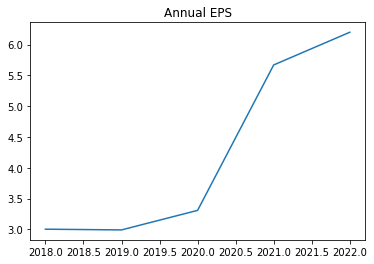

In [54]:
# estimating [current_year] annual data using quarterly data
estimated_earnings = current.quarterly_earnings['Earnings'].sum()
current_shares = current.info['sharesOutstanding']


annual_earnings[current_year] = estimated_earnings
shares[current_year] = current_shares

# EPS per year dictionary
annual_EPS = {}
for year in years_index:
    eps = annual_earnings.get(year)/shares.get(year)
    annual_EPS[year] = eps

plt.plot(years_index, annual_EPS.values())
plt.title('Annual EPS')

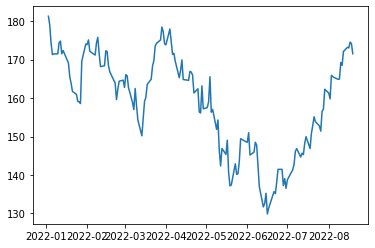

In [63]:
# Splitting 5yr hist into respective years
years_index_timestamp = [pd.Timestamp(year = y, month = 1, day = 1) for y in years_index]

yearly_hist = {}
for i in range(len(years_index_timestamp) - 1):
    start = years_index_timestamp[i]
    cutoff = years_index_timestamp[i+1]
    
    close = current.history(start = start, end=cutoff)
    yearly_hist[years_index[i]] = close
    
yearly_hist[years_index[-1]] = current.history(start = years_index_timestamp[-1], end=None)
plt.plot(yearly_hist[2022]['Close'])



In [64]:
# Getting daily PE ratios for each year based on annual_EPS and yearly_hist
yearly_PE = {}
for year in years_index:
    close = yearly_hist[year]['Close'].to_list()
    PE_ratio = [price/annual_EPS[year] for price in close]
    yearly_PE[year] = PE_ratio

{2018: [13.657537884746326,
  13.655165252305686,
  13.718588714988185,
  13.874781089983026,
  13.823244922274803,
  13.821659780258786,
  13.818489496226753,
  13.896981969228177,
  14.040486857365657,
  13.969130063727999,
  14.199848246246685,
  14.212529382374814,
  14.14910464954647,
  14.033351178001892,
  14.036520191888078,
  13.812937688733157,
  13.566361735325078,
  13.598078547249711,
  13.316618038176657,
  13.23812937561277,
  13.274599073293762,
  13.302346679449125,
  12.725154302575483,
  12.407227906258974,
  12.92574462562309,
  12.649042082889775,
  12.300981476372957,
  12.451442953309892,
  12.95297274212737,
  13.08273211191763,
  13.323942969271501,
  13.77134041227119,
  13.726754482633192,
  13.68058595127087,
  13.61849106114346,
  13.732330422897865,
  13.971152135915096,
  14.247393615706251,
  14.201218733614699,
  14.179726595751708,
  13.931349575533762,
  14.027677436507064,
  14.076237652497717,
  14.064295741252057,
  13.93373999001625,
  14.08579041

In [65]:
dictionary = {} 
dictionary[f'{ticker} Annual PE ratio'] = yearly_PE

In [66]:
import json
def save(ticker):
    f = open(f"data/{ticker}.txt", "w") #Write has 3 options - w (write create file if doesnt exist), a(append to end of file), x(create)
    f.write(json.dumps(dictionary))
    f.close()

save(ticker)



In [ ]:
f = open(f"data/{ticker}.txt", "r")
type(json.loads(f.read()))

In [ ]:
plt.plot(yearly_PE[2022])
plt.title('Annual pe ratio')